# Identify the time a waterbody first exceeds X% wet surface area <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`environment only. You can make this notebook `Sandbox` compatible by pointing it to the DEA Waterbodies timeseries located in AWS.
* **Products used:** 
None.
* **Prerequisites:** This notebook explores the individual waterbody timeseries csvs contained within the DEA Waterbodies dataset. It has been designed with that very specific purpose in mind, and is not intended as a general analysis notebook. 

## Description
This notebook loops through all of the individual DEA Waterbodies timeseries files and finds the quarter (JFM/AMJ/JAS/OND) that each waterbody is first observed at having at least `SurfaceAreaThreshold`% of the total surface area of the waterbody observed as wet. This attribute is used as a proxy for construction date for built waterbody structures. This date is then appended to the waterbody polygon shapefile as an attribute. 

1. Load in the required modules
2. Set up the file paths for inputs/outputs
3. Read in the DEA Waterbodies shapefile
4. Loop through each timeseries and find the quarter where the waterbody is first observed at having at least X% of the total surface area of the waterbody observed as wet
5. Append this date to the shapefile
6. Write out an updated shapefile
7. Load in the shapefile again (done as a separate step so you can choose to start to run the notebook from here without re-doing the analysis)
8. Groupby the dates and sum the area of all the polygons first observed in that quarter
9. Plot the results

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import fiona
import geopandas as gp
import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Analysis parameters
* `WaterBodyRiverFiltered`: file path to the DEA Waterbodies shapefile to read in
* `CSVFolder`: file path to the folder of DEA Waterbodies timeseries
* `SurfaceAreaThreshold`: e.g. 50. Select the percentage of the total surface area of the waterbody that must have been observed as wet as a single time period. 

In [2]:
WaterBodyRiverFiltered = '/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/AusAllTime01-005HybridWaterbodies/AusWaterBodiesRiverFiltered.shp'
CSVFolder = '/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/timeseries_aus_uid/'
SurfaceAreaThreshold = 50

### Read in data and loop through each timeseries

In [3]:
WaterBodyRiverFilteredShapes = gp.read_file(WaterBodyRiverFiltered)
# Set up an empty attribute to write into
WaterBodyRiverFilteredShapes[f'Time First Exceeds {SurfaceAreaThreshold}%'] = -999

In [6]:
PolygonsThatDidntWork = []

for shapes in fiona.open(WaterBodyRiverFiltered):
    polyName = shapes['properties']['UID']

    # Read in the correct csv file
    FileToLoad = f'{CSVFolder}{polyName[:4]}/{polyName}.csv'
    try:
        Timeseries = pd.read_csv(FileToLoad)
    except:
        print(f'Can\'t open{FileToLoad}')
        continue

    # Change the date column to an actual datetime object
    Timeseries['Observation Date'] = pd.to_datetime(
        Timeseries['Observation Date'])
    Timeseries = Timeseries.set_index(['Observation Date'])

    # Aggregate the timeseries quarterly
    QuartelyAveraged = Timeseries.resample('Q', label='left').agg('max')

    try:
        # Find the first time that the timeseries is greater than or equal to 50%
        IndexFirstExceeds = np.where(
            QuartelyAveraged['Wet pixel percentage'] >= SurfaceAreaThreshold)[0][0]
        TimeFirstExceeds = QuartelyAveraged.iloc[IndexFirstExceeds]
        DateString, BitToThrowOut = str(TimeFirstExceeds.name).split(' ')

    except:
        print('Another one that didn\'t work...')
        PolygonsThatDidntWork.append(polyName)
        continue
    # Put the values back into the dataframe
    WaterBodyRiverFilteredShapes.at[WaterBodyRiverFilteredShapes.loc[
        WaterBodyRiverFilteredShapes['UID'] ==
        polyName].index, f'Time First Exceeds {SurfaceAreaThreshold}%'] = DateString

WaterBodyRiverFilteredShapes.to_file(
    '/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/AusAllTime01-005HybridWaterbodies/AusWaterBodiesRiverFilteredTimeseriesExceed50.shp'
)

Another one that didn't work...
Another one that didn't work...
Another one that didn't work...
Another one that didn't work...


KeyboardInterrupt: 

## Calculate some statistics on the timing of waterbodies being first observed as at least 50% wet
Load back in the new appended shapefile and add up the total surface area of waterbodies that were first seen as at least 50% wet in each quarter through time.

In [2]:
AllTheData = gp.read_file('/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/AusAllTime01-005HybridWaterbodies/AusWaterBodiesRiverFilteredTimeseriesExceed50.shp')

### Group the data by quarter, remove missing values and convert to $km^2$

In [3]:
# Group all the waterbodies by quarters and sum them up
GroupedData = AllTheData.groupby(by='Time First').sum()
# Drop the -999 missing values
CleanedData = GroupedData.drop('-999')

In [4]:
# Convert the quarter dates to a pandas datetime object
CleanedData.index = pd.to_datetime(CleanedData.index)
# Convert from m2 to km2
CleanedData['area'] = CleanedData['area'] / 1000000

### Plot the results

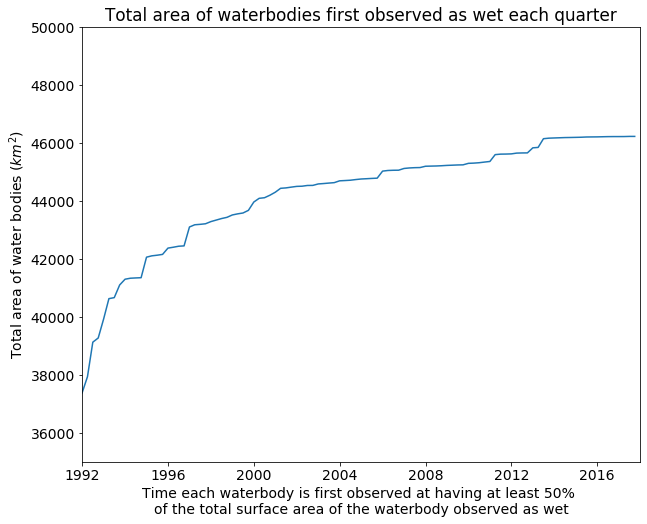

In [14]:
plt.figure(figsize=[10, 8])
plt.plot(CleanedData.area.cumsum())
plt.xlim('1992-01-01', '2018-01-01')
plt.ylim(35000, 50000)
plt.ylabel('Total area of water bodies ($km^2$)')
plt.xlabel('Time each waterbody is first observed at having at least 50% \n'
           'of the total surface area of the waterbody observed as wet')
plt.title('Total area of waterbodies first observed as wet each quarter')
plt.rcParams["font.size"] = "14"

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** N/A

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)